# Phishing Attempt Detection Algorithm Through URL Analysis

## Environement Preparation

In [1]:
# Library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from scipy.stats import yeojohnson
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import optuna
import joblib
import warnings
# We also filter warnings emitted by the 'seaborn_oldcore' library to improve the readability of our outputs.
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn._oldcore')

# Reading the data.
df = pd.read_csv('Phishing_Legitimate_full.csv')

c:\Users\bouch\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preparation

In [2]:
# Exploring our data.
print(f"{df.dtypes}\n") 
# Data dimensions.
print(f"Dimensions: {df.shape[0]} x {df.shape[1]}\n")
# Classification of data types.
datatype_counts = df.dtypes.value_counts()
for dtype, count in datatype_counts.items():
    print(f"{dtype}: {count} columns")

# Dropping the 'id' column.
df = df.drop("id", axis=1)
#Distribution verification
df.describe()


id                                      int64
NumDots                                 int64
SubdomainLevel                          int64
PathLevel                               int64
UrlLength                               int64
NumDash                                 int64
NumDashInHostname                       int64
AtSymbol                                int64
TildeSymbol                             int64
NumUnderscore                           int64
NumPercent                              int64
NumQueryComponents                      int64
NumAmpersand                            int64
NumHash                                 int64
NumNumericChars                         int64
NoHttps                                 int64
RandomString                            int64
IpAddress                               int64
DomainInSubdomains                      int64
DomainInPaths                           int64
HttpsInHostname                         int64
HostnameLength                    

NumDots  SubdomainLevel     PathLevel     UrlLength       NumDash  \
count  10000.000000    10000.000000  10000.000000  10000.000000  10000.000000   
mean       2.445100        0.586800      3.300300     70.264100      1.818000   
std        1.346836        0.751214      1.863241     33.369877      3.106258   
min        1.000000        0.000000      0.000000     12.000000      0.000000   
25%        2.000000        0.000000      2.000000     48.000000      0.000000   
50%        2.000000        1.000000      3.000000     62.000000      0.000000   
75%        3.000000        1.000000      4.000000     84.000000      2.000000   
max       21.000000       14.000000     18.000000    253.000000     55.000000   

       NumDashInHostname      AtSymbol   TildeSymbol  NumUnderscore  \
count       10000.000000  10000.000000  10000.000000    10000.00000   
mean            0.138900      0.000300      0.013100        0.32320   
std             0.545744      0.017319      0.113709        1.11466   
min             0.000000      0.000000      0.000000        0.00000   
25%             0.000000      0.000000      0.000000        0.00000   
50%             0.000000      0.000000      0.000000        0.00000   
75%             0.000000      0.000000      0.000000        0.00000   
max             9.000000      1.000000      1.000000       18.00000   

         NumPercent  ...  IframeOrFrame  MissingTitle  ImagesOnlyInForm  \
count  10000.000000  ...   10000.000000   10000.00000      10000.000000   
mean       0.073800  ...       0.339600       0.03220          0.030400   
std        0.622248  ...       0.473597       0.17654          0.171694   
min        0.000000  ...       0.000000       0.00000          0.000000   
25%        0.000000  ...       0.000000       0.00000          0.000000   
50%        0.000000  ...       0.000000       0.00000          0.000000   
75%        0.000000  ...       1.000000       0.00000          0.000000   
max       19.000000  ...       1.000000       1.00000          1.000000   

       SubdomainLevelRT   UrlLengthRT  PctExtResourceUrlsRT  \
count      10000.000000  10000.000000          10000.000000   
mean           0.956600      0.020200              0.353300   
std            0.248037      0.820036              0.888908   
min           -1.000000     -1.000000             -1.000000   
25%            1.000000     -1.000000             -1.000000   
50%            1.000000      0.000000              1.000000   
75%            1.000000      1.000000              1.000000   
max            1.000000      1.000000              1.000000   

       AbnormalExtFormActionR  ExtMetaScriptLinkRT  \
count            10000.000000         10000.000000   
mean                 0.793200             0.173400   
std                  0.521019             0.755771   
min                 -1.000000            -1.000000   
25%                  1.000000             0.000000   
50%                  1.000000             0.000000   
75%                  1.000000             1.000000   
max                  1.000000             1.000000   

       PctExtNullSelfRedirectHyperlinksRT   CLASS_LABEL  
count                        10000.000000  10000.000000  
mean                             0.314100      0.500000  
std                              0.897843      0.500025  
min                             -1.000000      0.000000  
25%                             -1.000000      0.000000  
50%                              1.000000      0.500000  
75%                              1.000000      1.000000  
max                              1.000000      1.000000  

[8 rows x 49 columns]

In [3]:
# Checking for missing values.
null = df.isnull().sum()
for i in range(len(df.columns)):
    print(f"{df.columns[i]}: {null[i]} ({(null[i]/len(df))*100}%)")
total_cells = np.prod(df.shape)
total_missing = null.sum()
print(f"\nTotal missing values: {total_missing} ({(total_missing/total_cells) * 100}%)\n")


NumDots: 0 (0.0%)
SubdomainLevel: 0 (0.0%)
PathLevel: 0 (0.0%)
UrlLength: 0 (0.0%)
NumDash: 0 (0.0%)
NumDashInHostname: 0 (0.0%)
AtSymbol: 0 (0.0%)
TildeSymbol: 0 (0.0%)
NumUnderscore: 0 (0.0%)
NumPercent: 0 (0.0%)
NumQueryComponents: 0 (0.0%)
NumAmpersand: 0 (0.0%)
NumHash: 0 (0.0%)
NumNumericChars: 0 (0.0%)
NoHttps: 0 (0.0%)
RandomString: 0 (0.0%)
IpAddress: 0 (0.0%)
DomainInSubdomains: 0 (0.0%)
DomainInPaths: 0 (0.0%)
HttpsInHostname: 0 (0.0%)
HostnameLength: 0 (0.0%)
PathLength: 0 (0.0%)
QueryLength: 0 (0.0%)
DoubleSlashInPath: 0 (0.0%)
NumSensitiveWords: 0 (0.0%)
EmbeddedBrandName: 0 (0.0%)
PctExtHyperlinks: 0 (0.0%)
PctExtResourceUrls: 0 (0.0%)
ExtFavicon: 0 (0.0%)
InsecureForms: 0 (0.0%)
RelativeFormAction: 0 (0.0%)
ExtFormAction: 0 (0.0%)
AbnormalFormAction: 0 (0.0%)
PctNullSelfRedirectHyperlinks: 0 (0.0%)
FrequentDomainNameMismatch: 0 (0.0%)
FakeLinkInStatusBar: 0 (0.0%)
RightClickDisabled: 0 (0.0%)
PopUpWindow: 0 (0.0%)
SubmitInfoToEmail: 0 (0.0%)
IframeOrFrame: 0 (0.0%)
Miss

C:\Users\bouch\AppData\Local\Temp\ipykernel_18608\2003421494.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{df.columns[i]}: {null[i]} ({(null[i]/len(df))*100}%)")


## Data Exploration

### Continuous variable and intervariable relationship

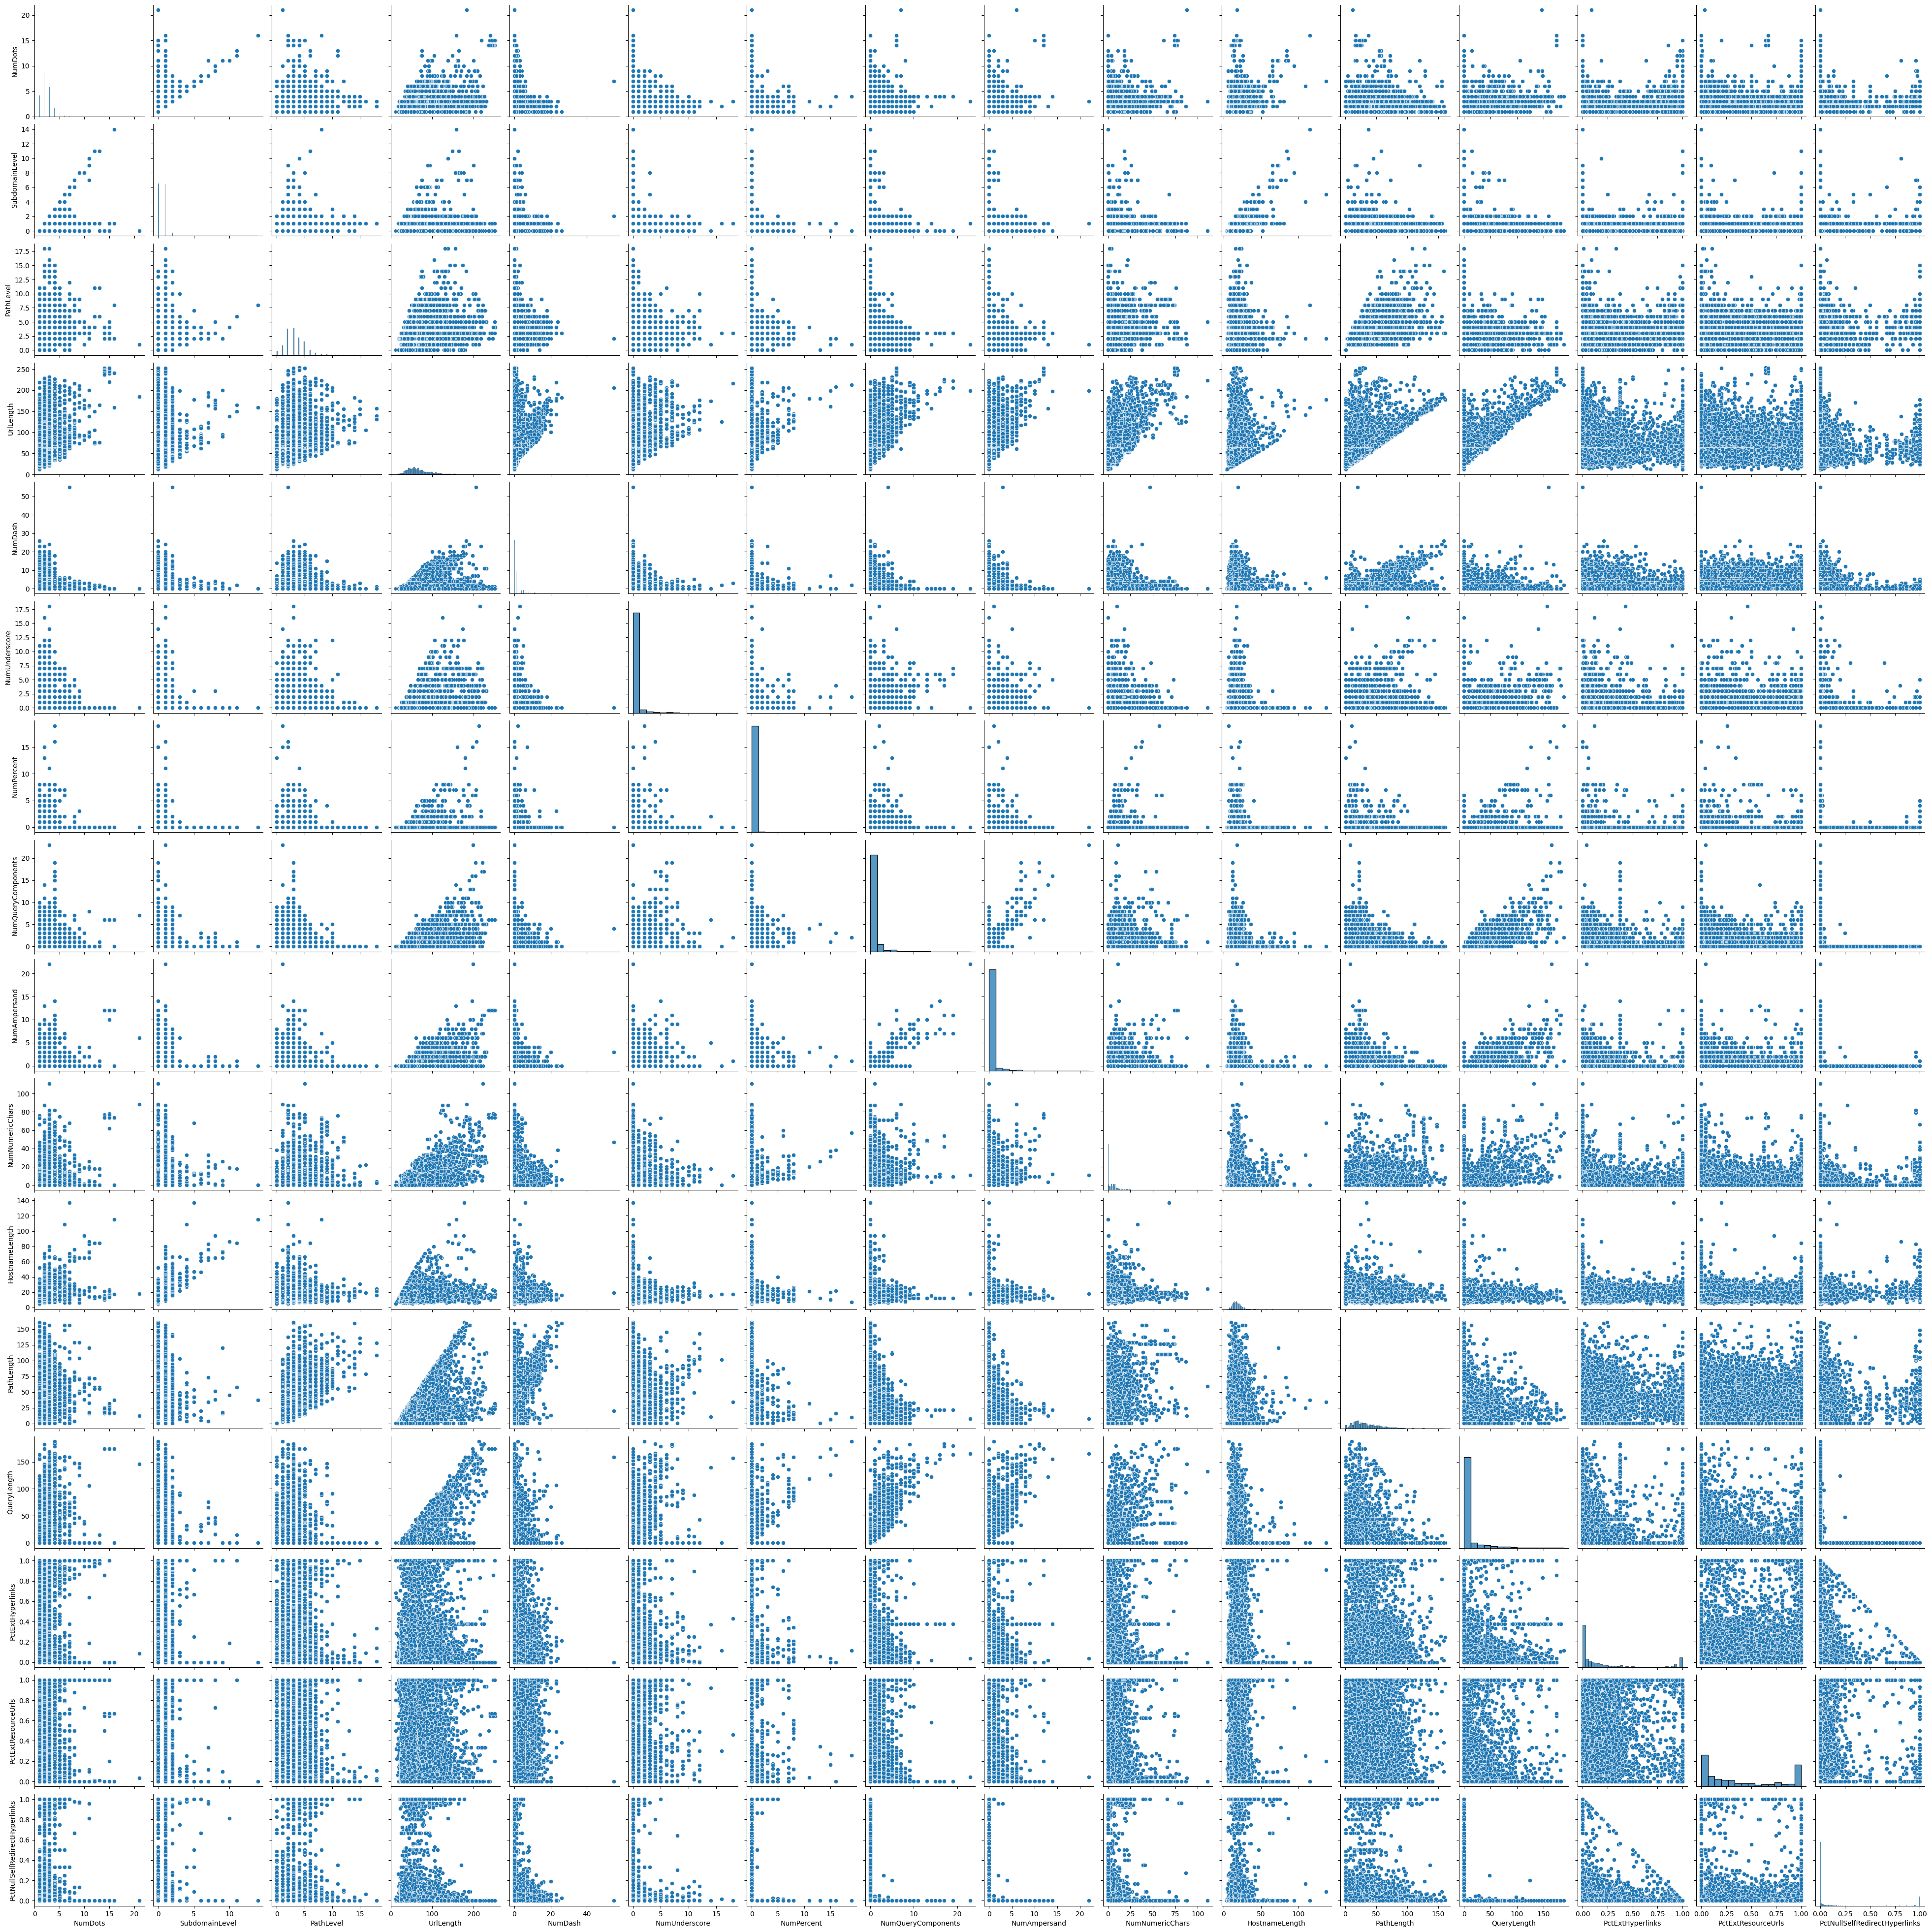

In [4]:
def is_continuous(series):
    return series.nunique() > 10

continuous_columns = [col for col in df.columns if is_continuous(df[col])]

sns.pairplot(df[continuous_columns], height= 2.5)
plt.show()

### Correlation and spread study

c:\Users\bouch\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\bouch\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


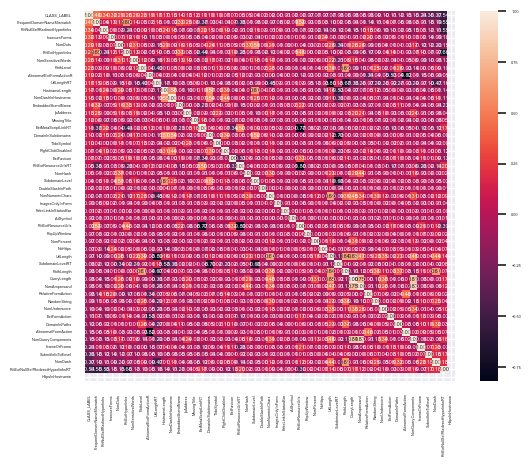

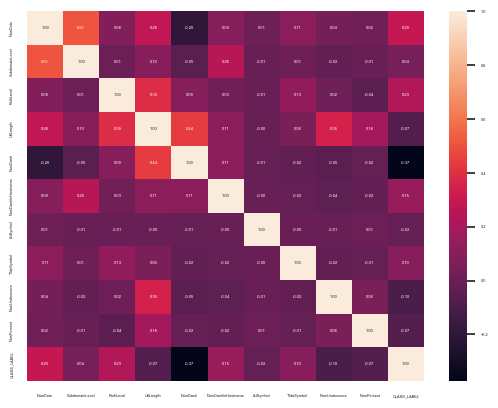

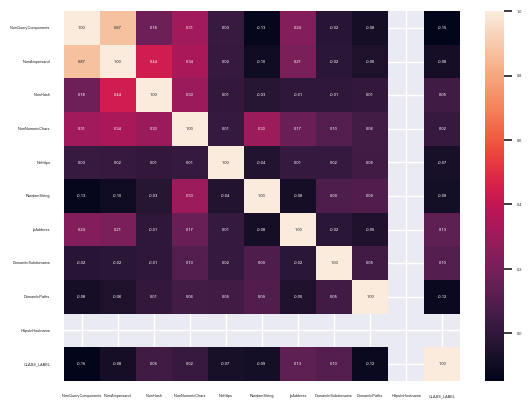

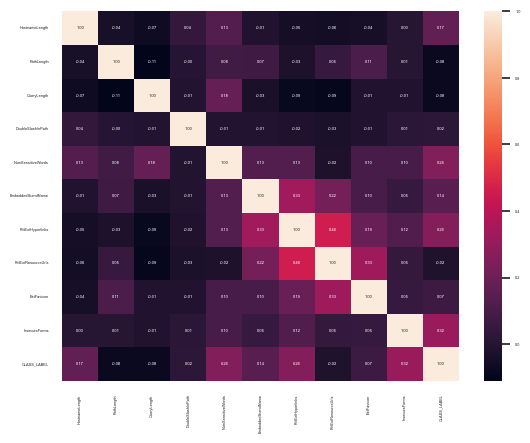

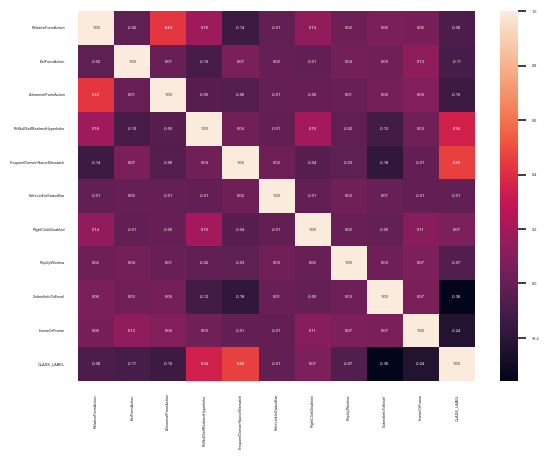

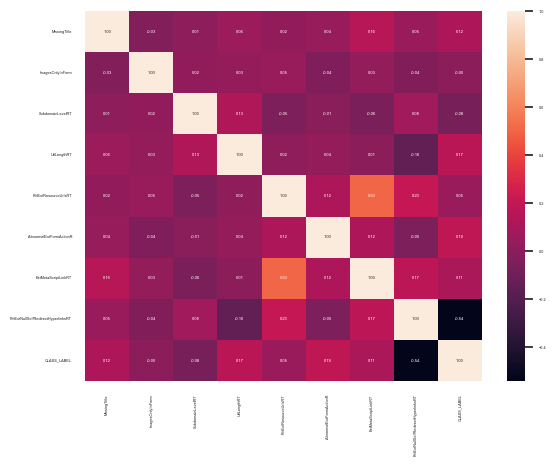

In [5]:
# Displaying correlations.
corr = df.corr()
cols = corr.nlargest(50, 'CLASS_LABEL')['CLASS_LABEL'].index
cm = np.corrcoef(df[cols].values.T)
sns.set_theme(font_scale=0.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 4}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#Adjusted display  .
def hm(df, idx_s, idx_e):
    y = df['CLASS_LABEL']
    temp = df.iloc[:, idx_s:idx_e]
    temp['CLASS_LABEL'] = y
    sns.heatmap(temp.corr(), annot=True, fmt='.2f')
    plt.show()
    
hm(df, 0, 10)
hm(df, 10, 20)
hm(df, 20, 30)
hm(df, 30, 40)
hm(df, 40, 50)

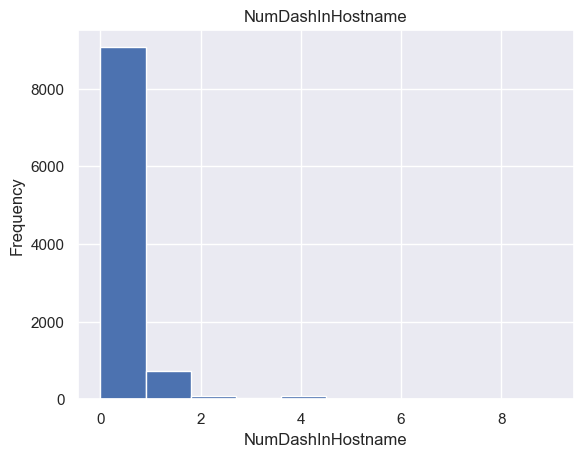

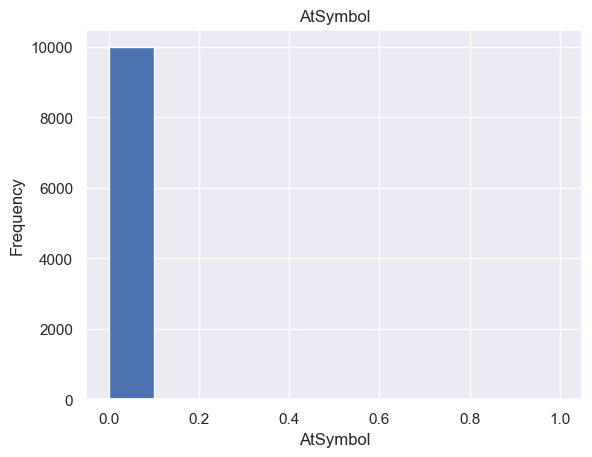

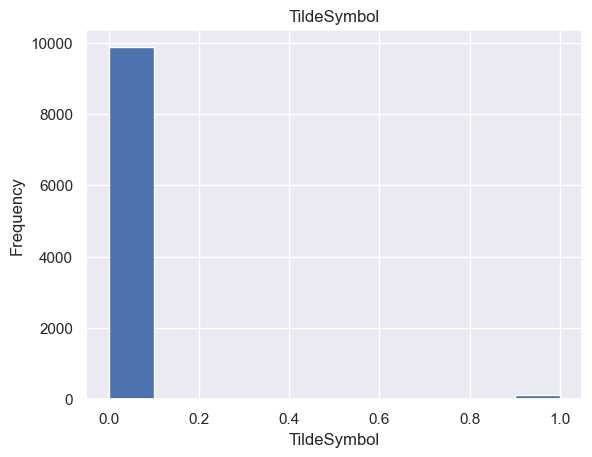

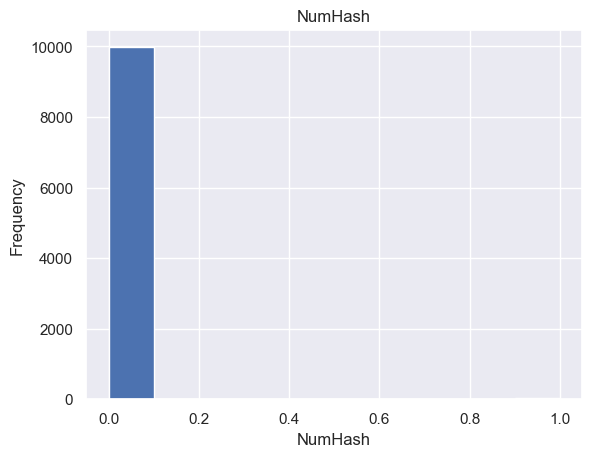

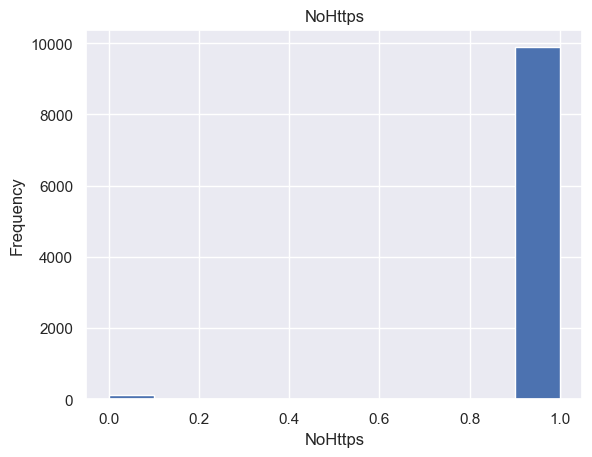

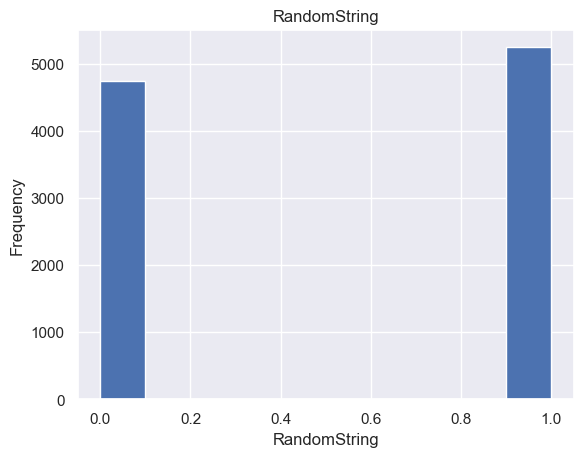

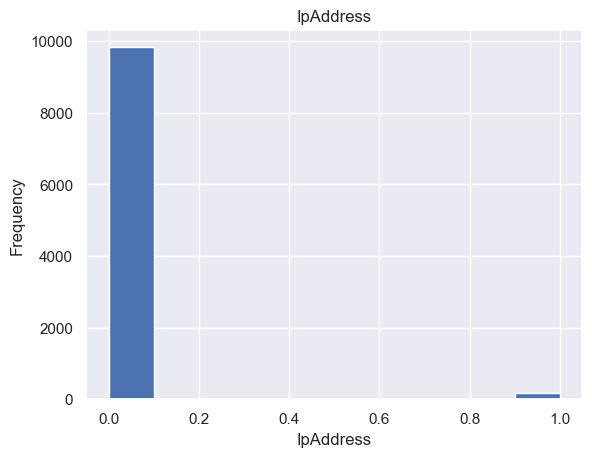

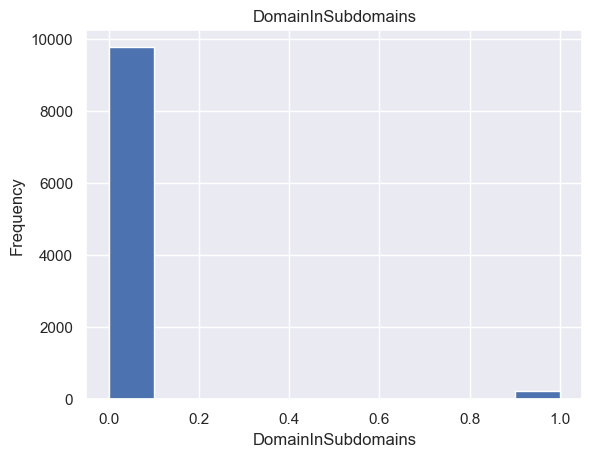

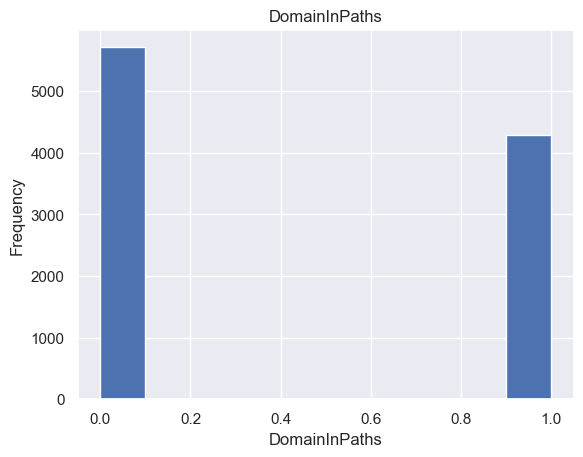

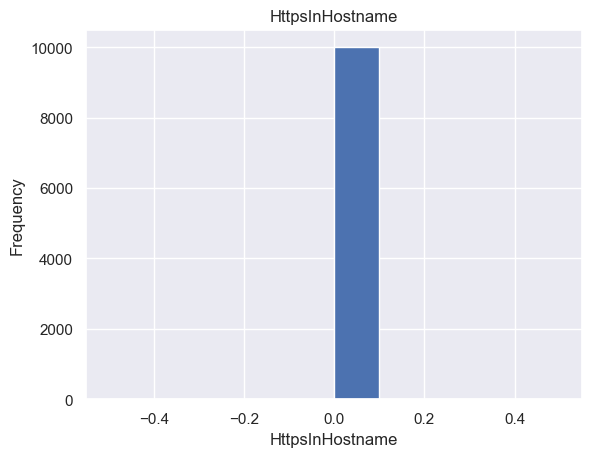

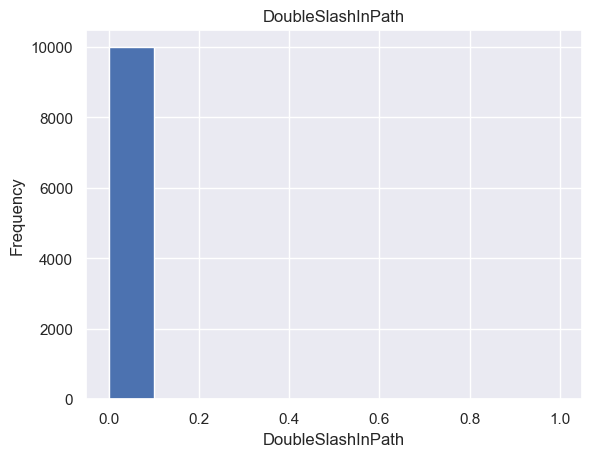

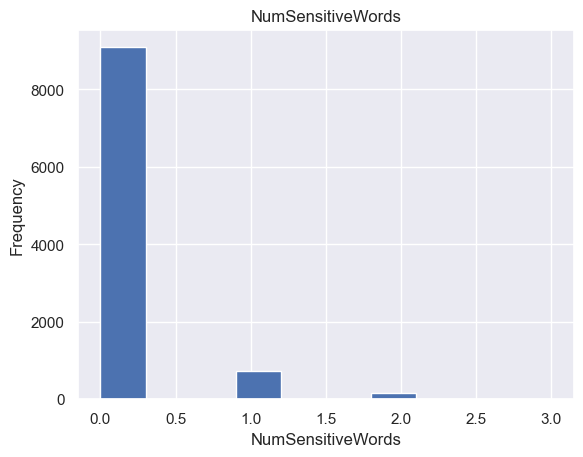

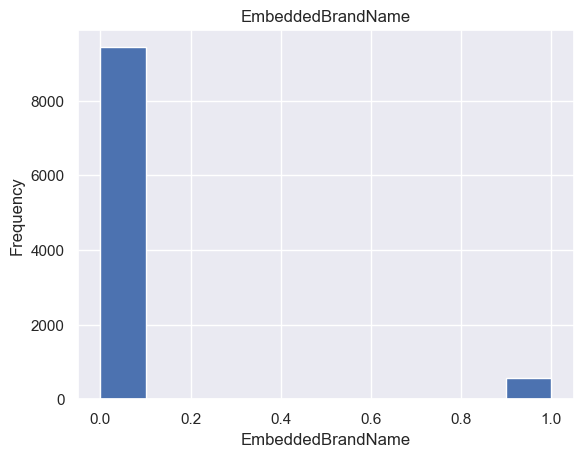

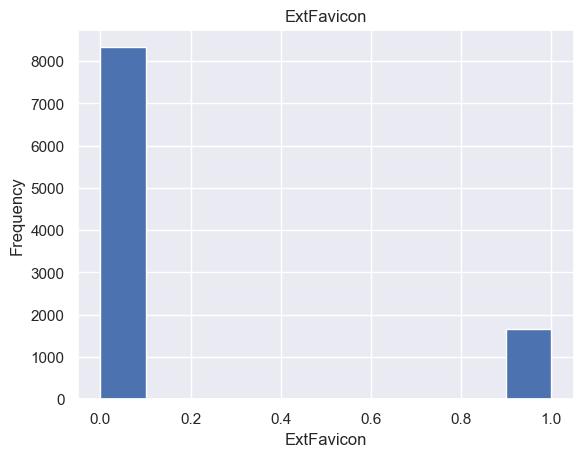

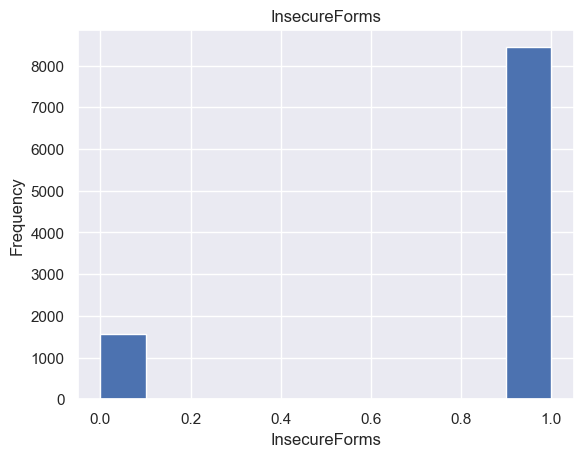

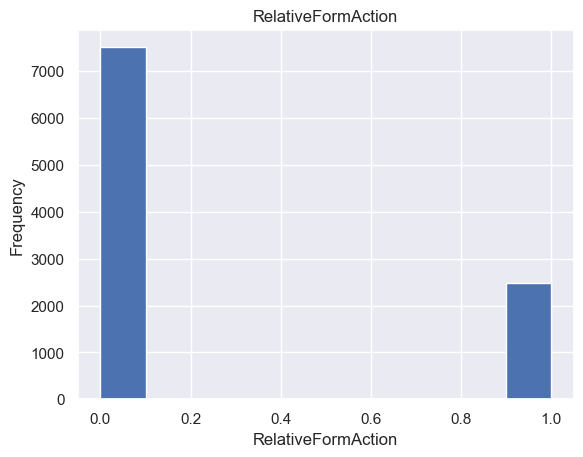

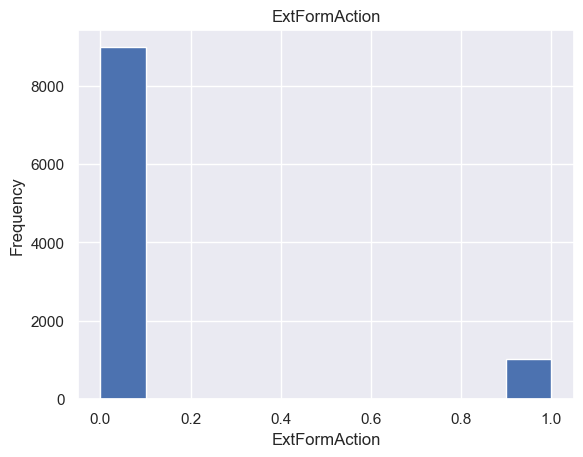

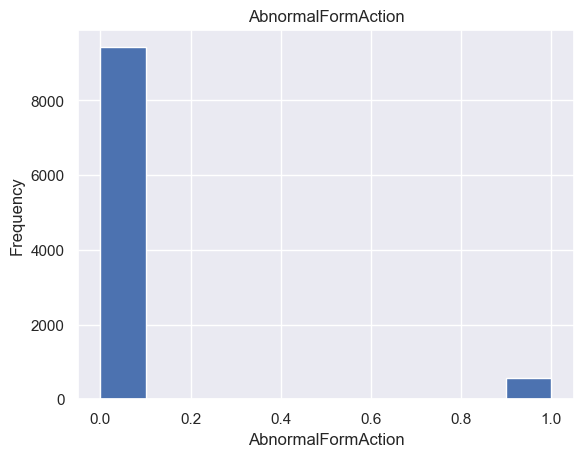

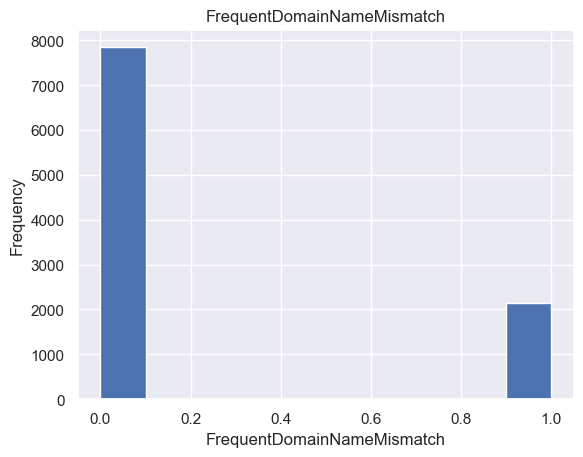

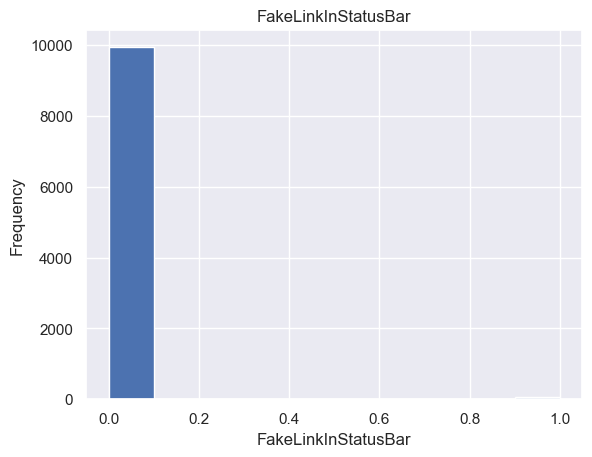

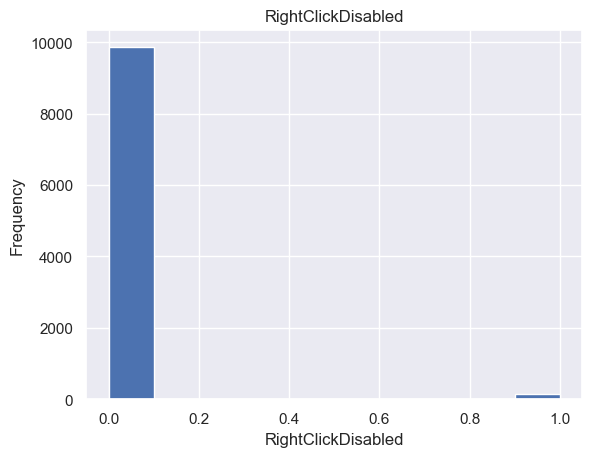

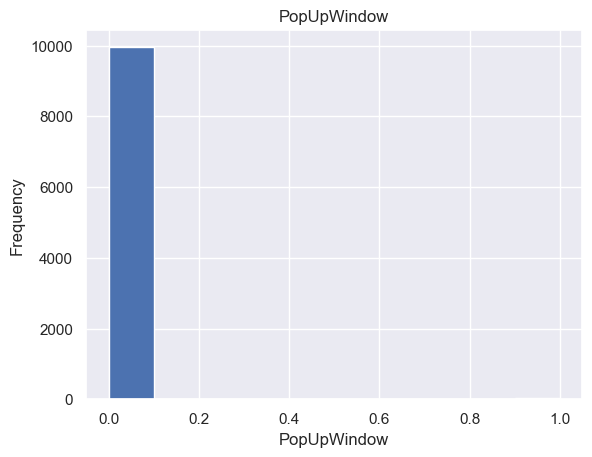

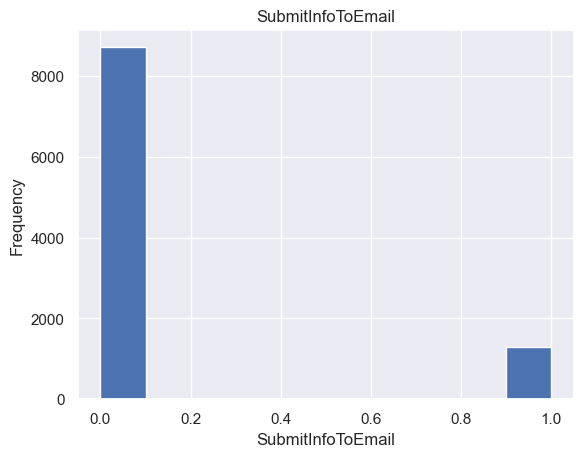

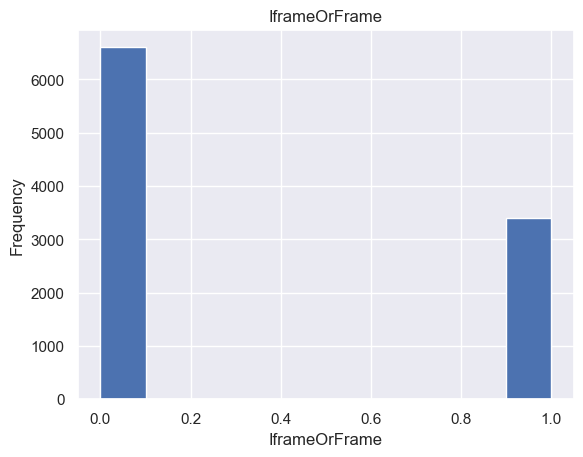

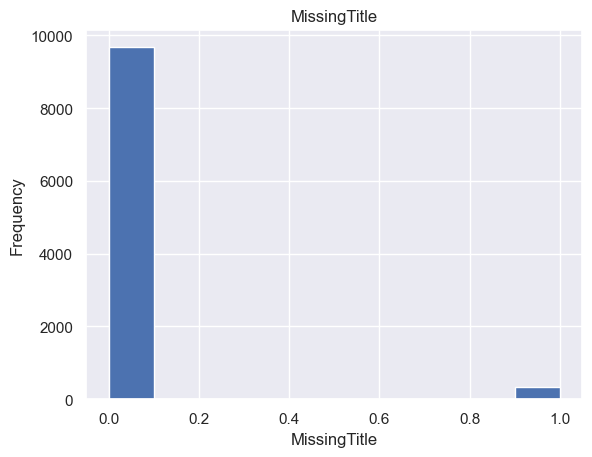

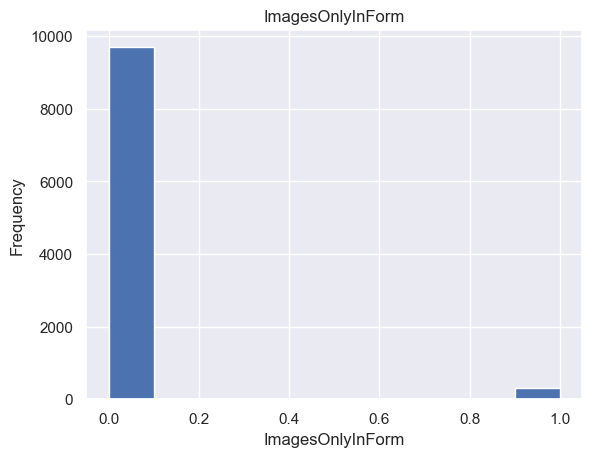

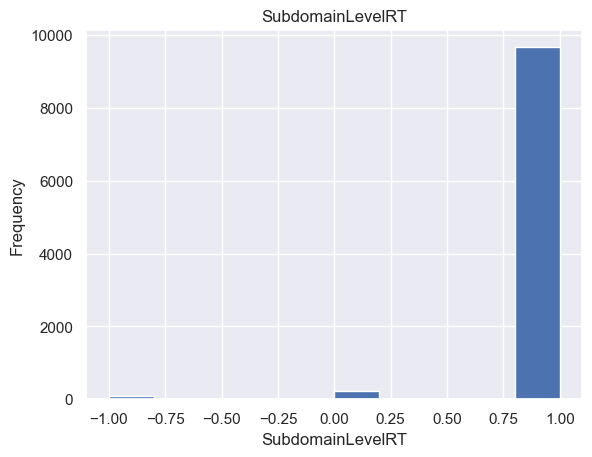

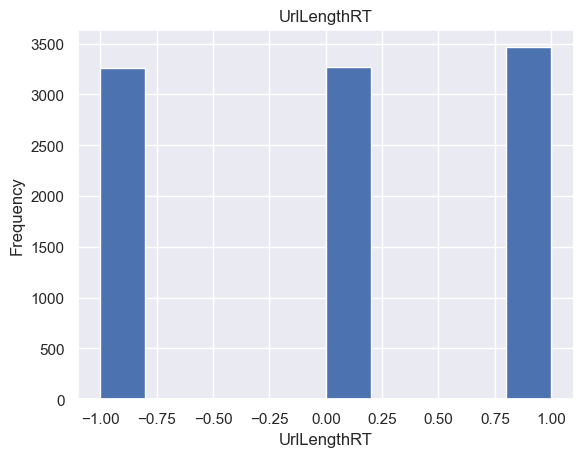

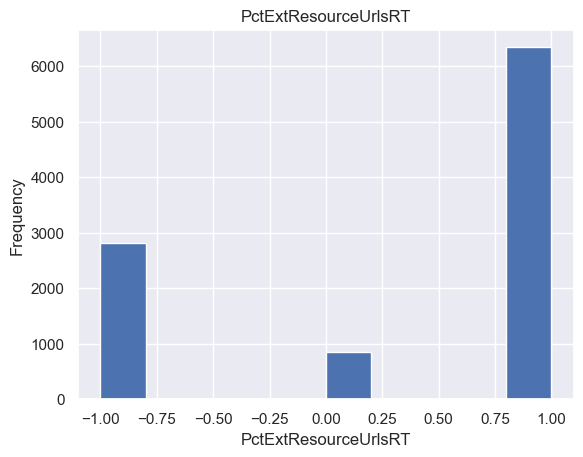

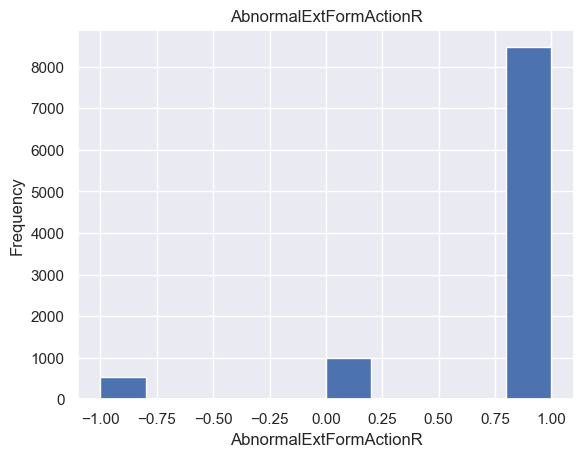

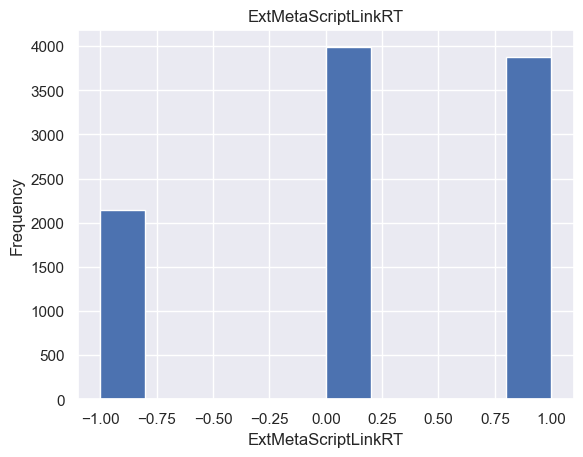

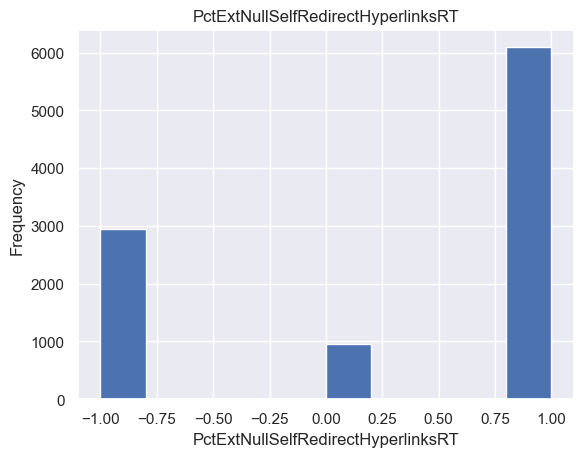

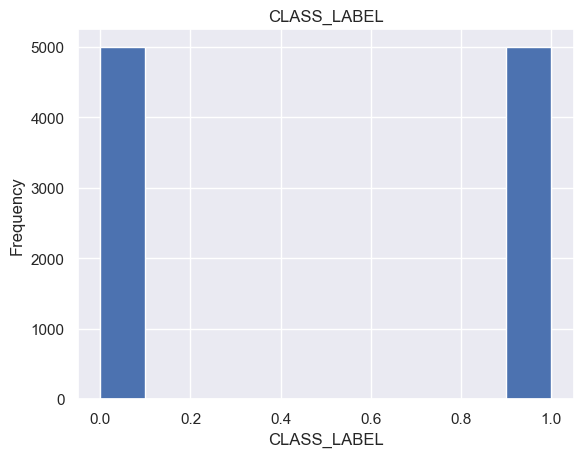

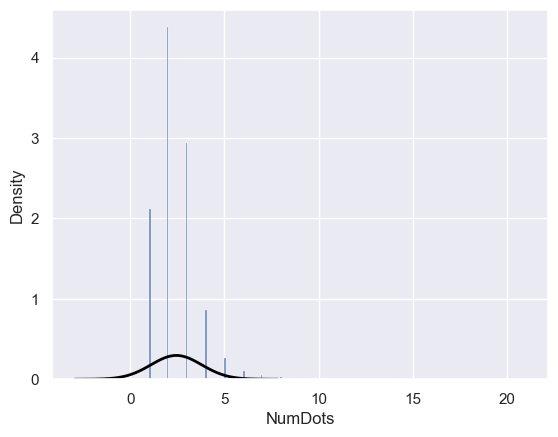

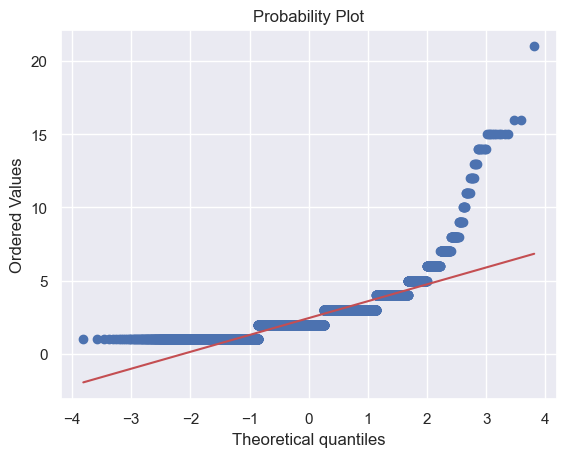

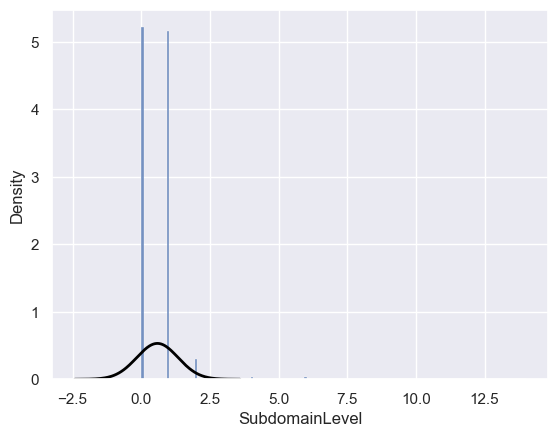

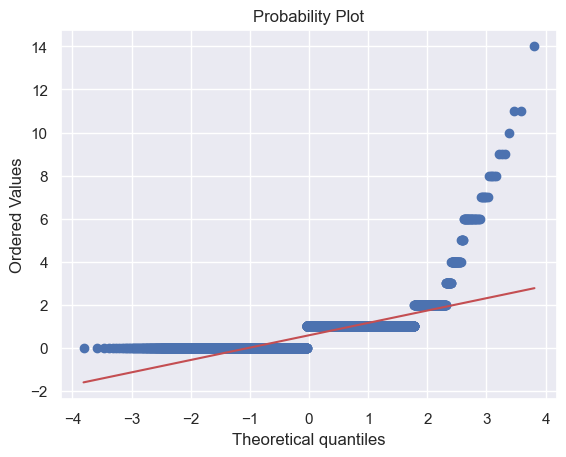

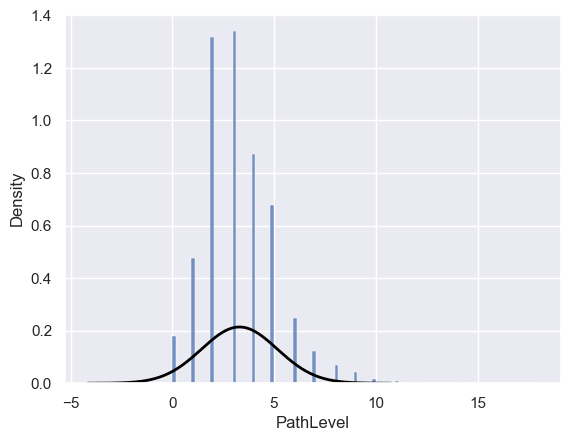

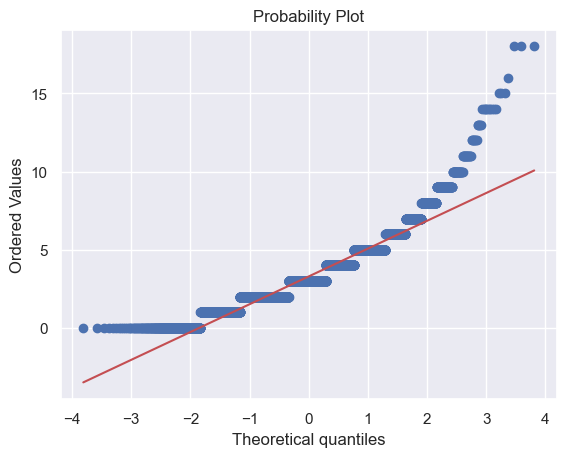

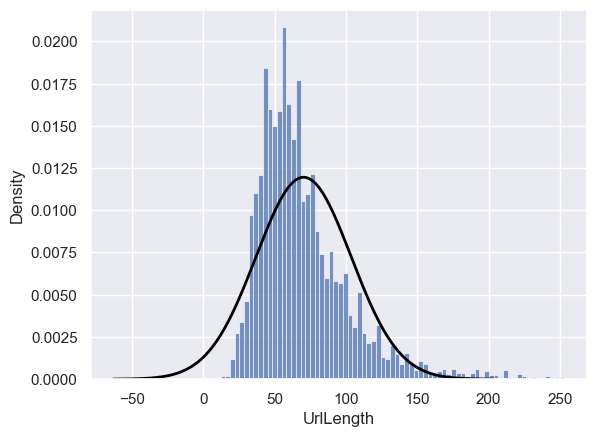

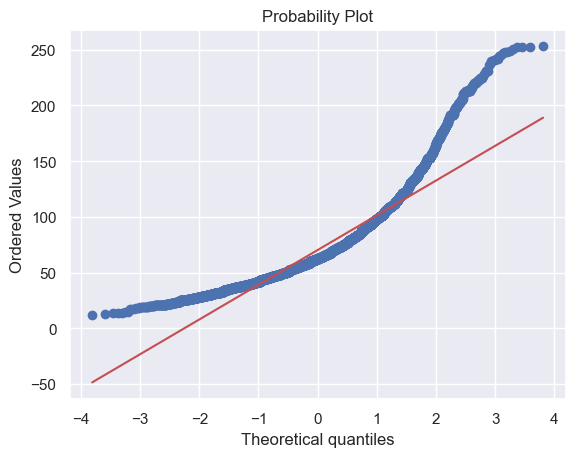

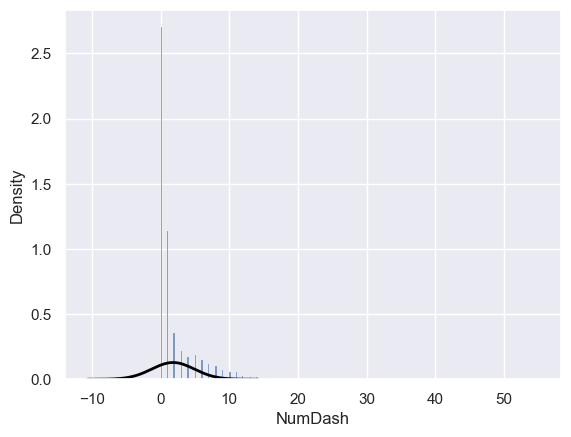

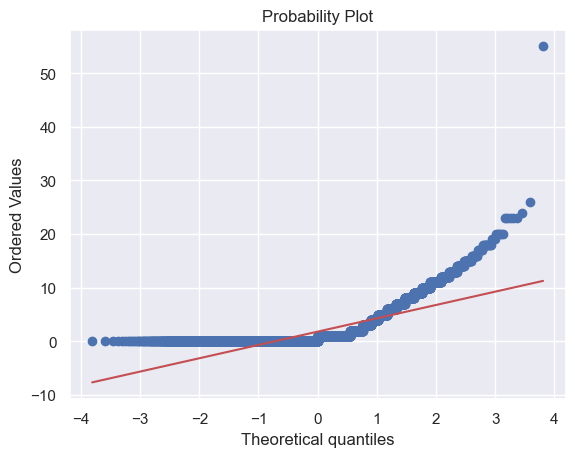

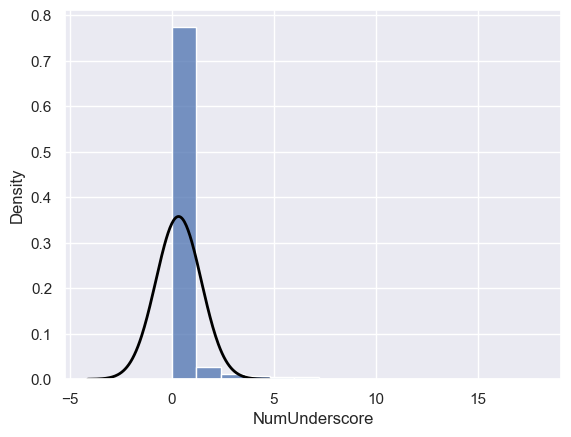

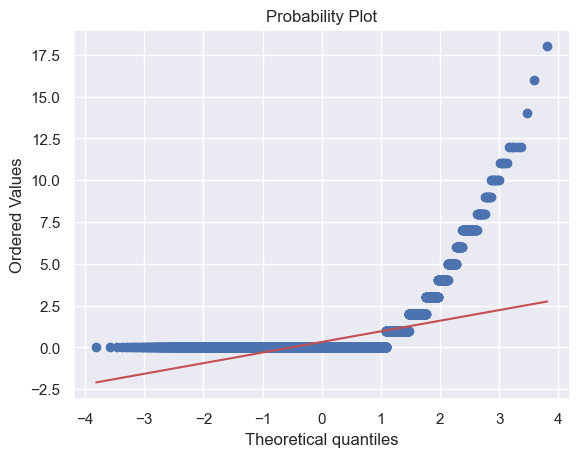

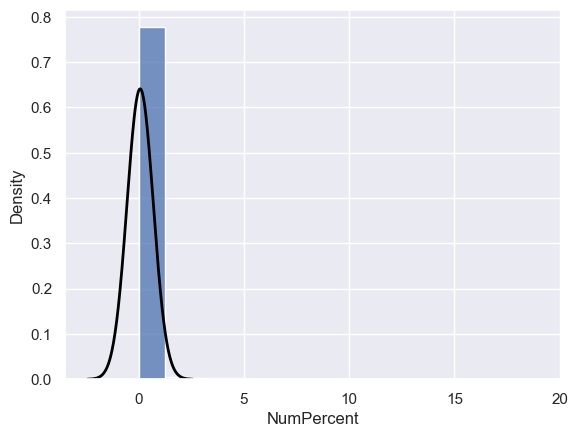

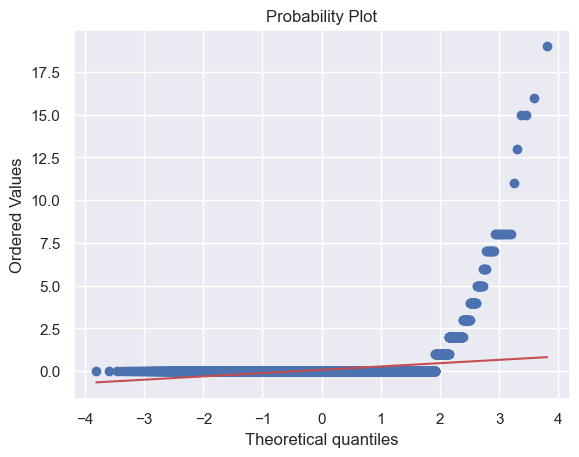

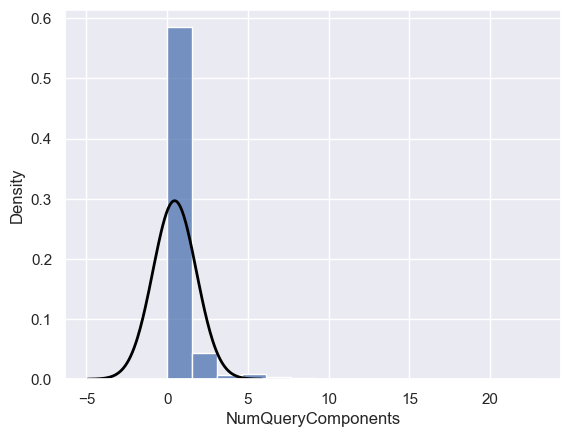

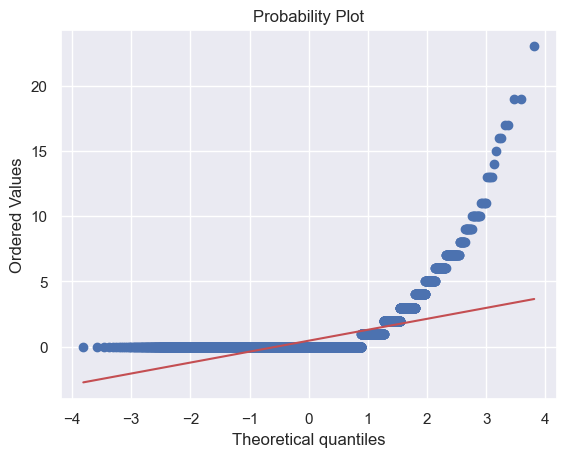

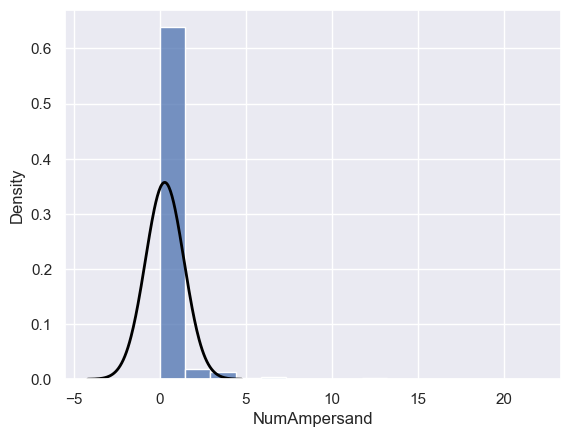

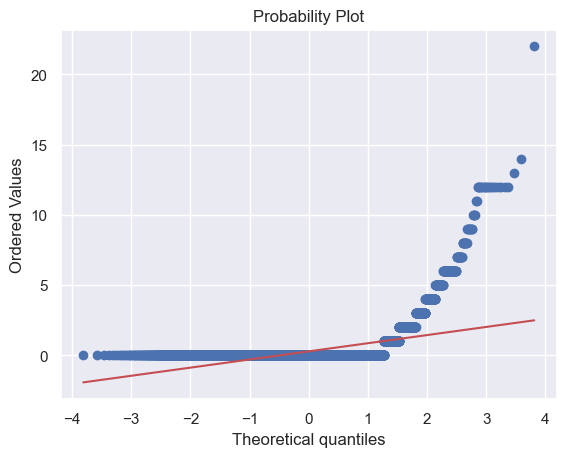

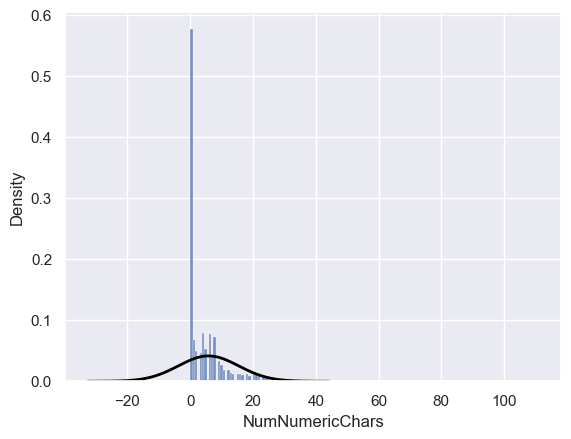

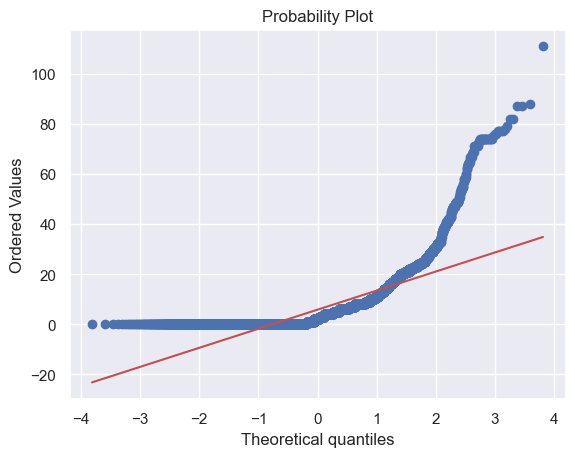

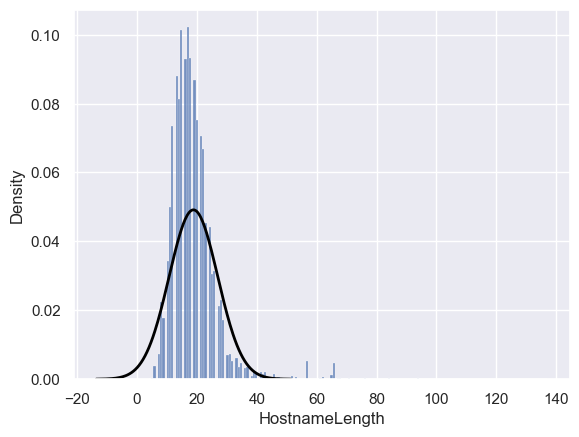

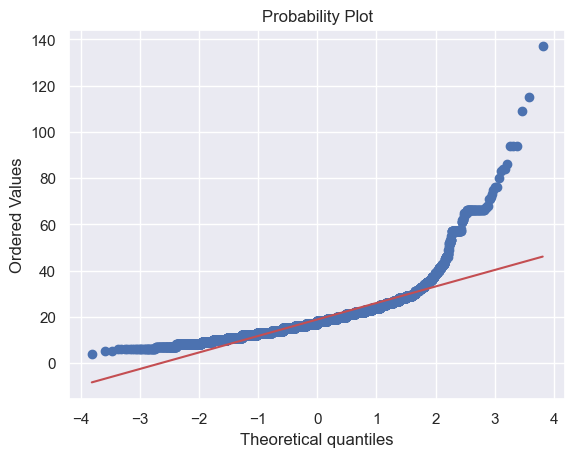

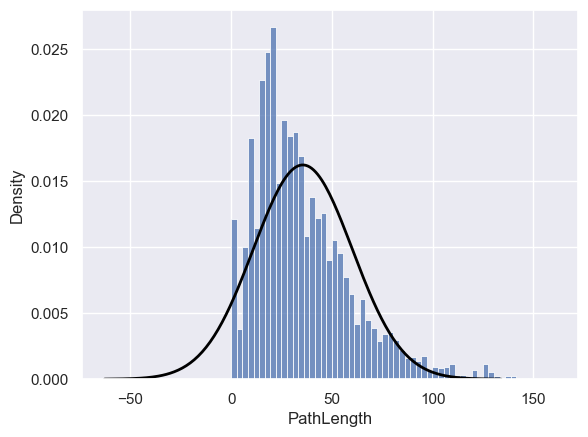

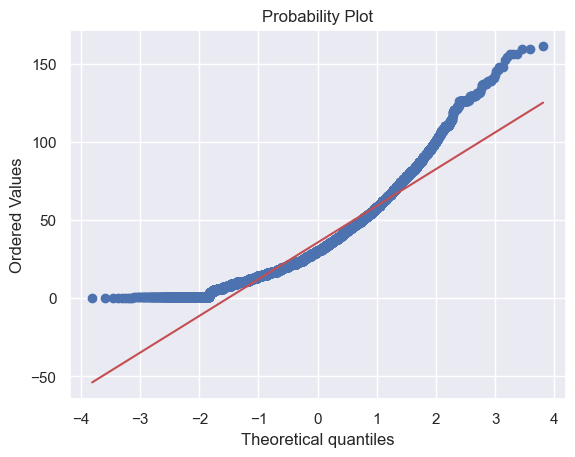

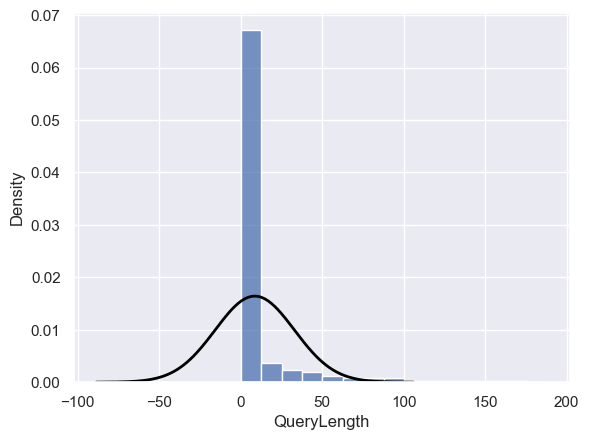

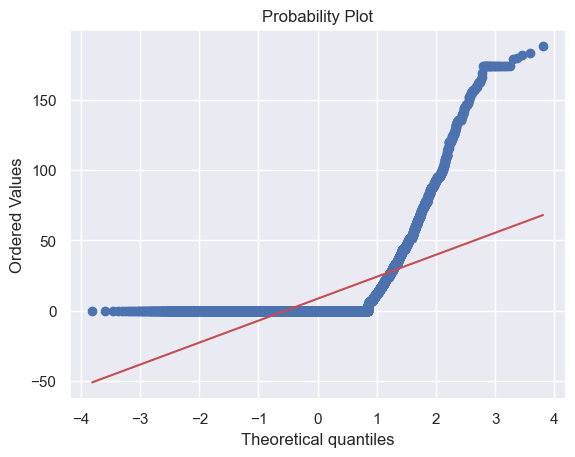

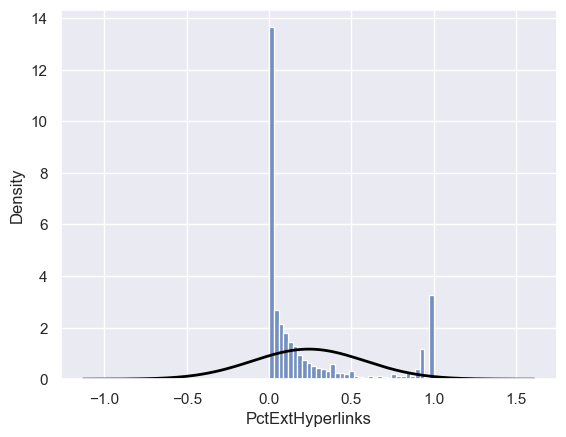

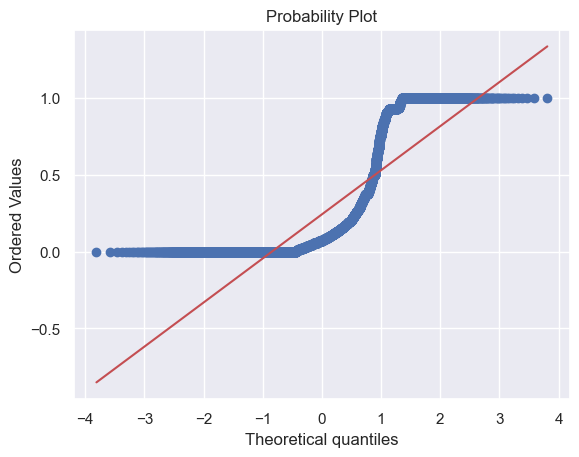

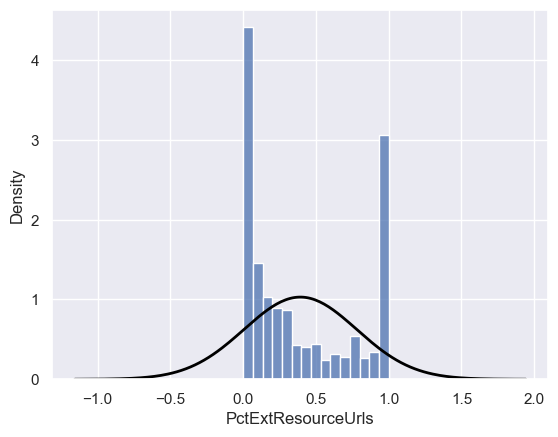

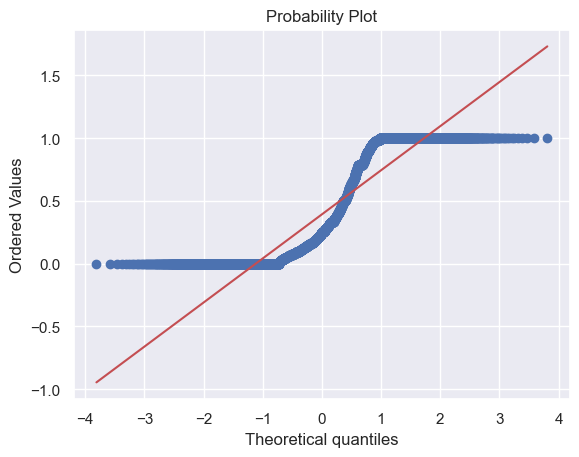

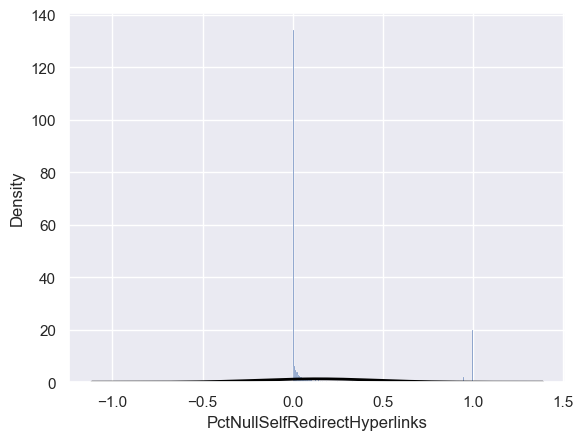

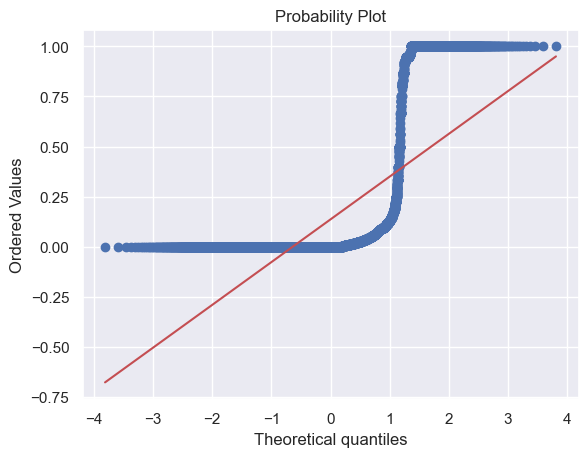

In [6]:
# Checking the spread of our data.
ordinal_columns = [col for col in df.columns if col not in continuous_columns]
sns.set_theme(font_scale=1)
for col in ordinal_columns:
    plt.hist(df[col], bins=10)  
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'{col}')
    plt.show()
    def normal(mean, std, color="black"):
        x = np.linspace(mean-4*std, mean+4*std, 200)
        p = stats.norm.pdf(x, mean, std)
        z = plt.plot(x, p, color, linewidth=2)

for column_name in continuous_columns:
    fig1, ax1 = plt.subplots()
    sns.histplot(x=df[column_name], stat="density", ax=ax1)
    normal(df[column_name].mean(), df[column_name].std())
    
    fig2, ax2 = plt.subplots()
    stats.probplot(df[column_name], plot=ax2)
    
    plt.show()

### Data cleansing

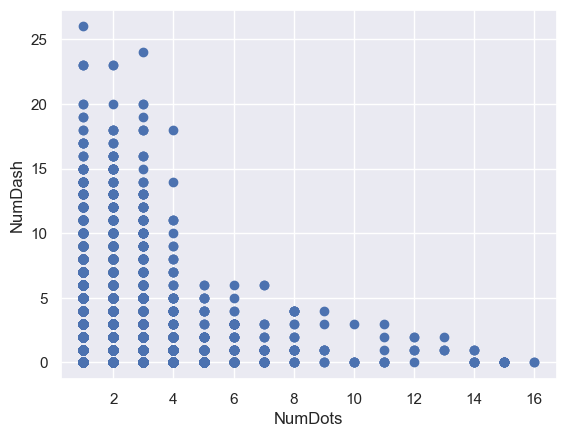

C:\Users\bouch\AppData\Local\Temp\ipykernel_18608\2932531679.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1, ax1 = plt.subplots()


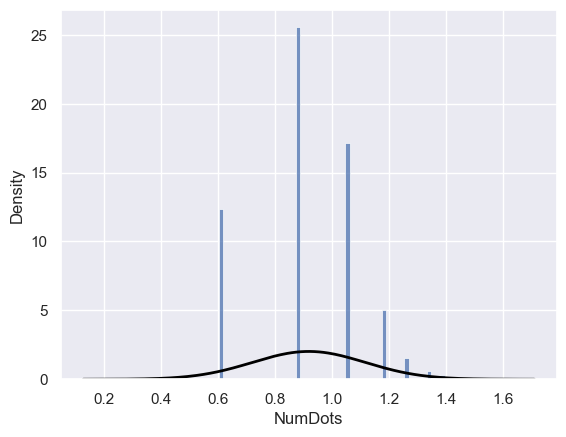

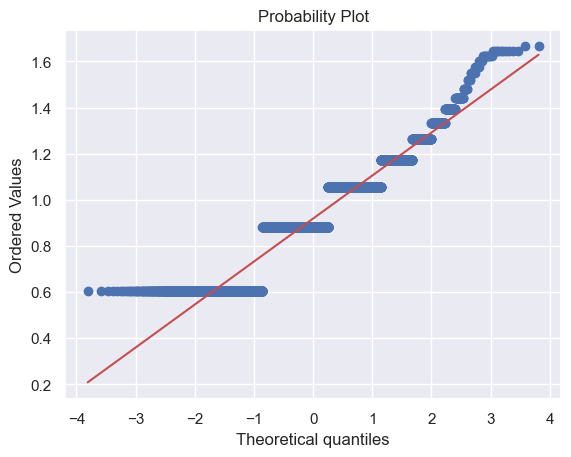

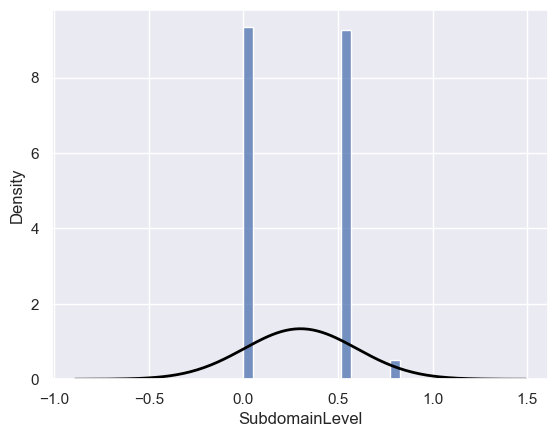

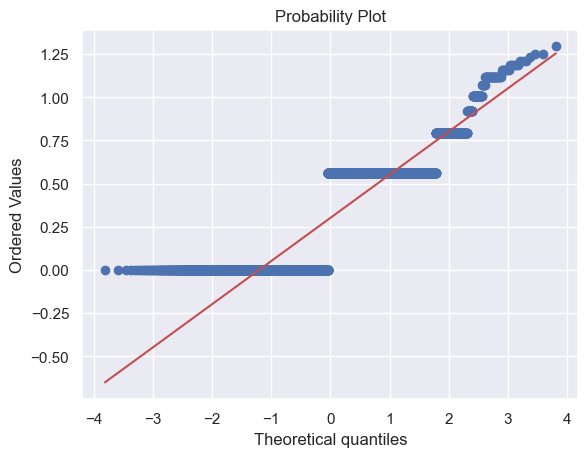

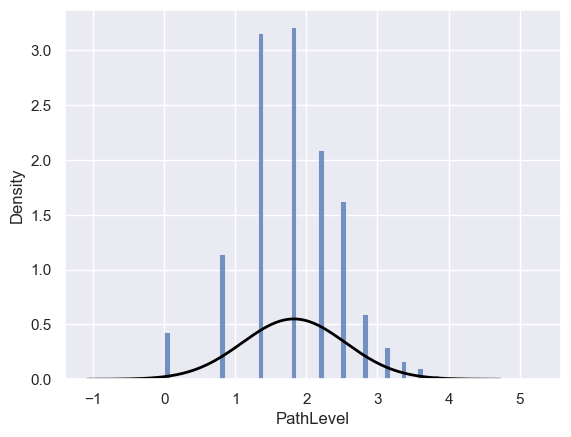

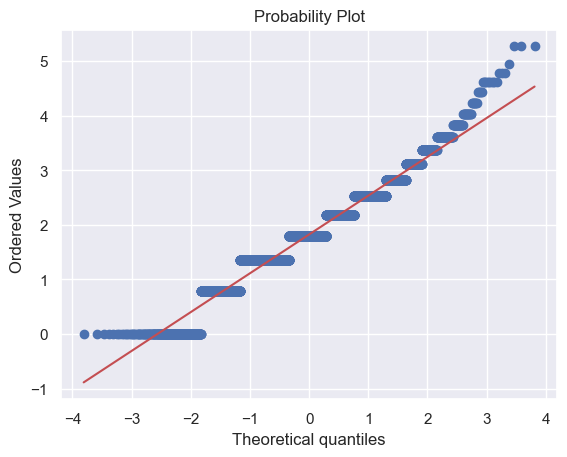

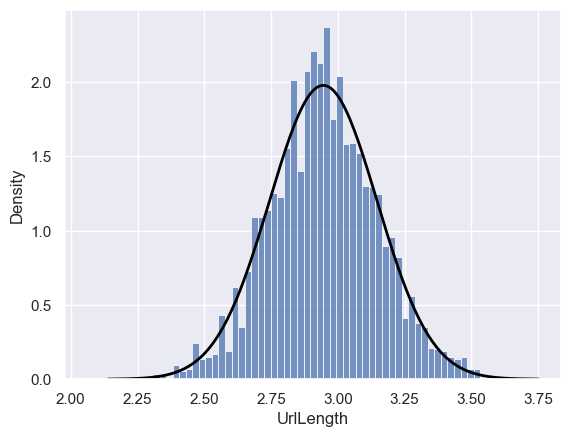

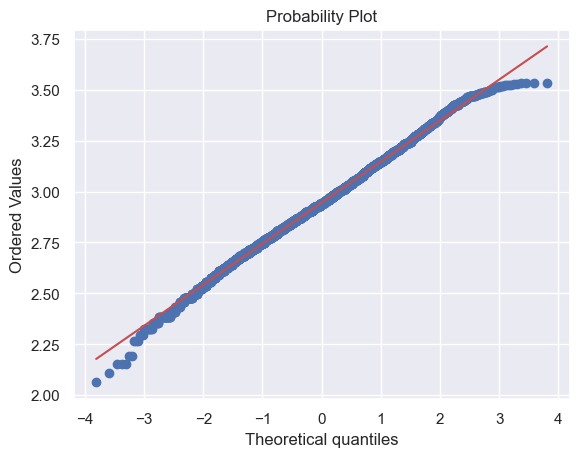

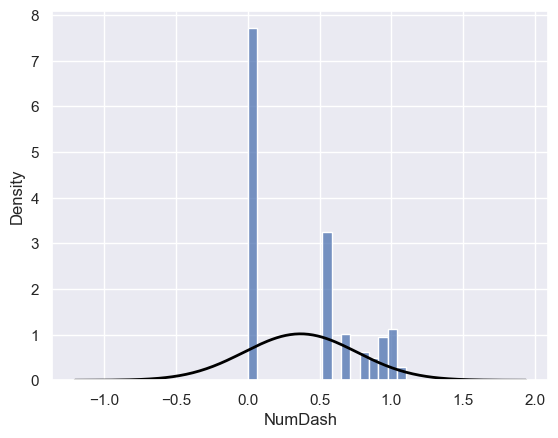

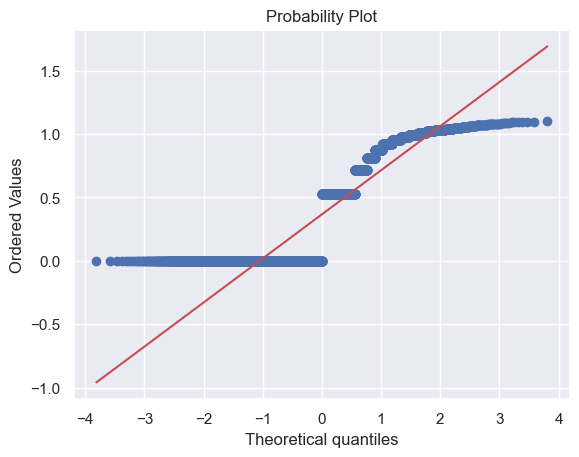

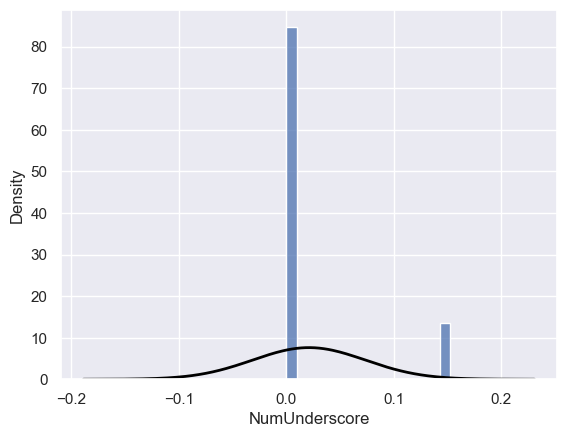

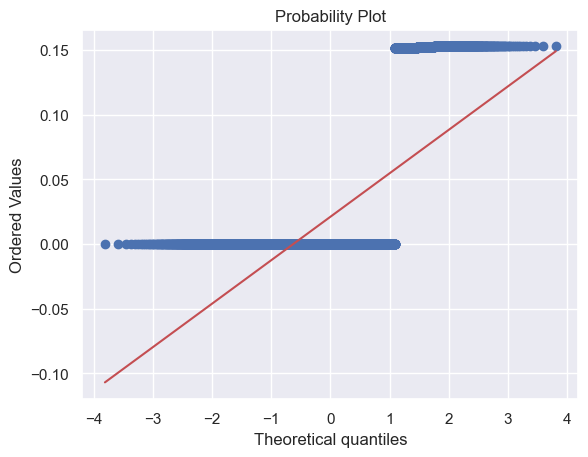

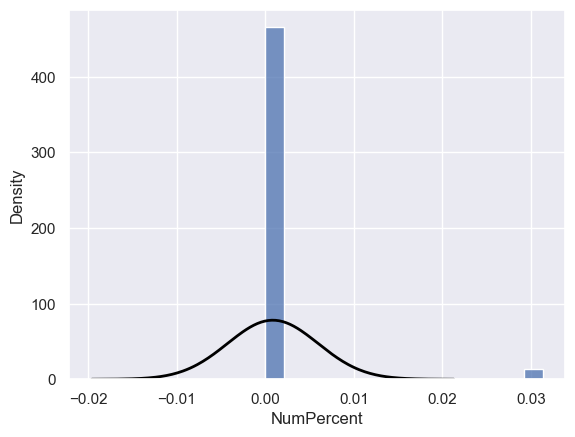

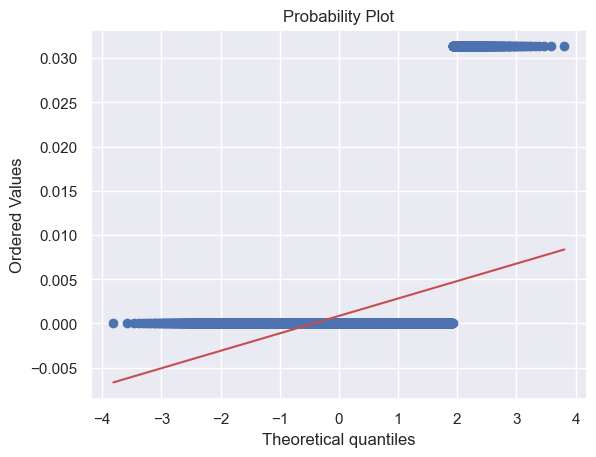

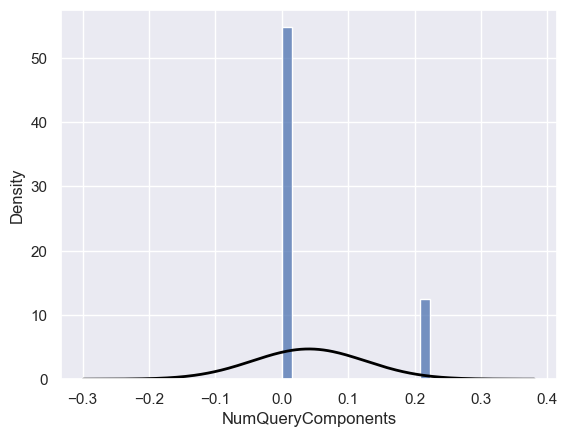

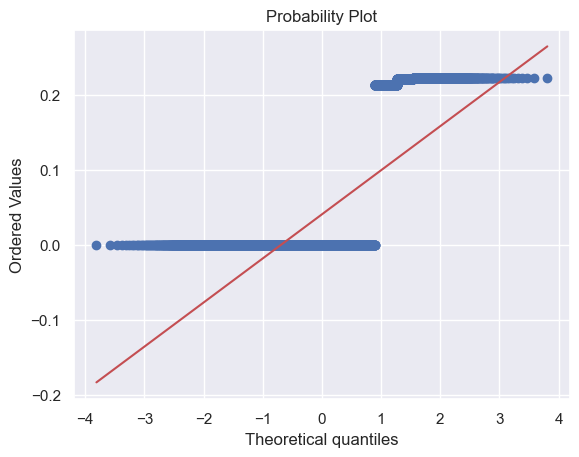

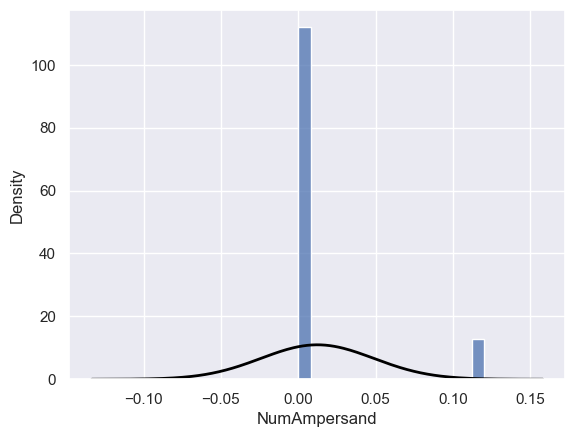

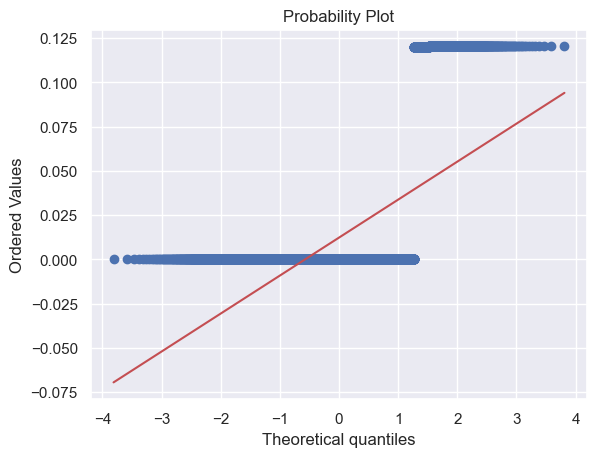

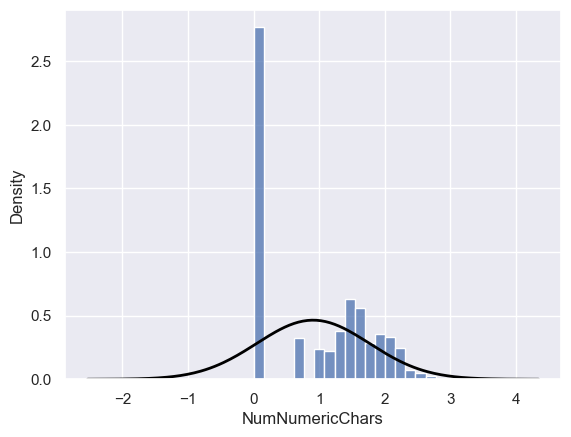

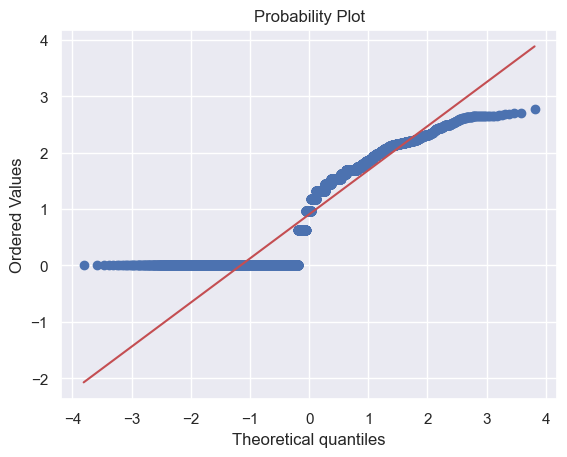

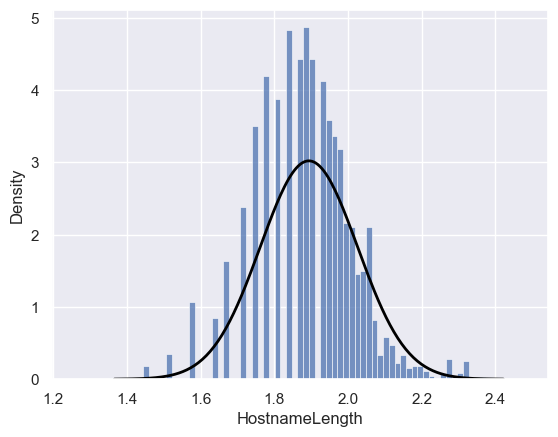

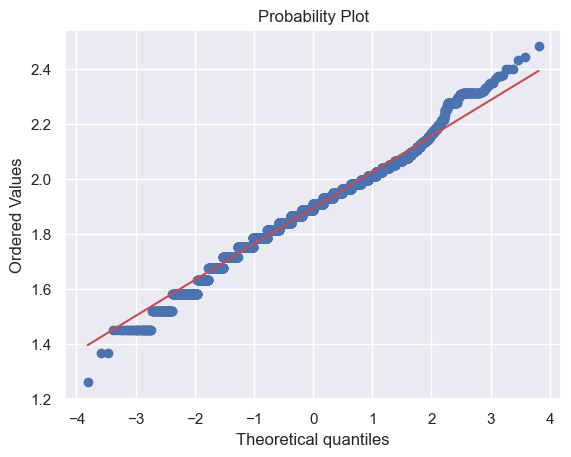

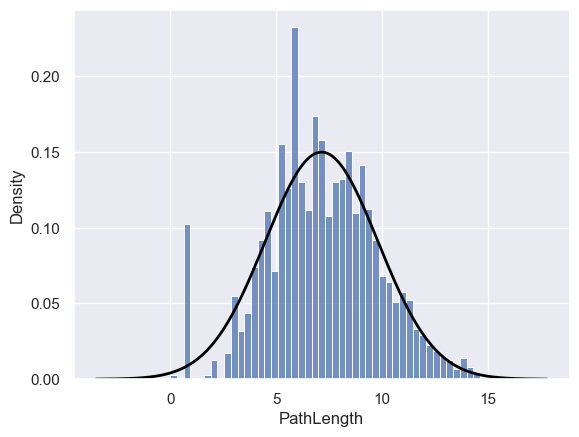

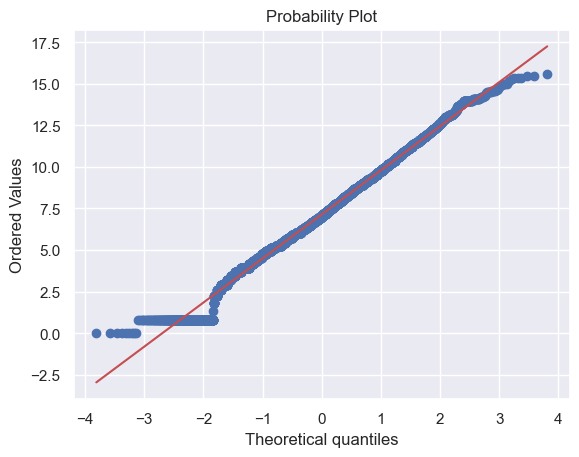

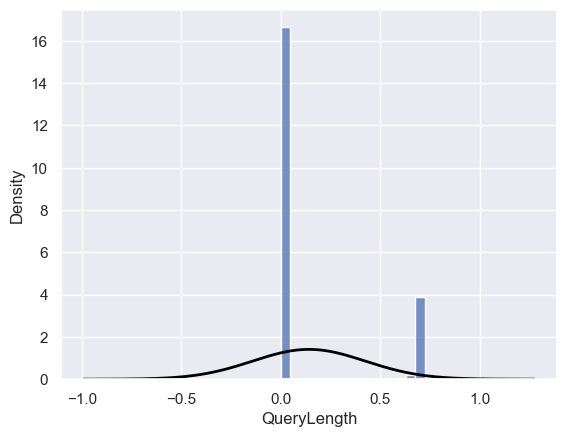

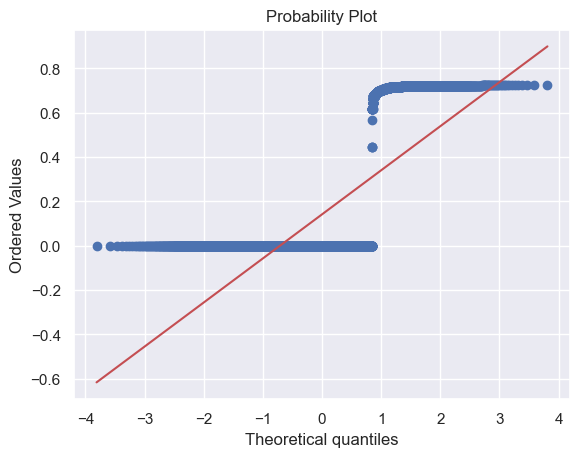

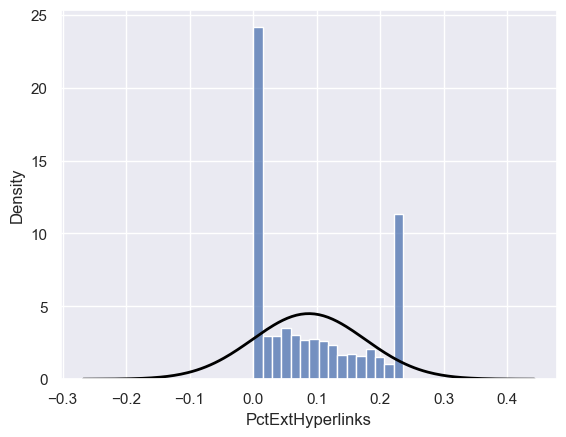

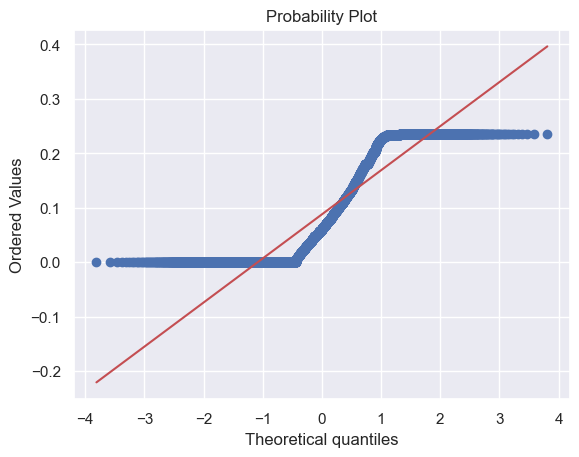

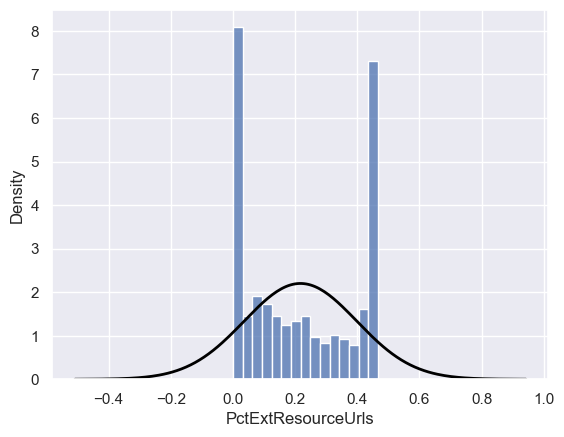

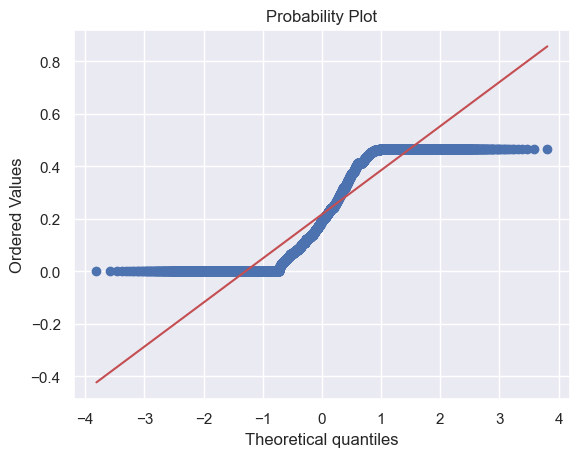

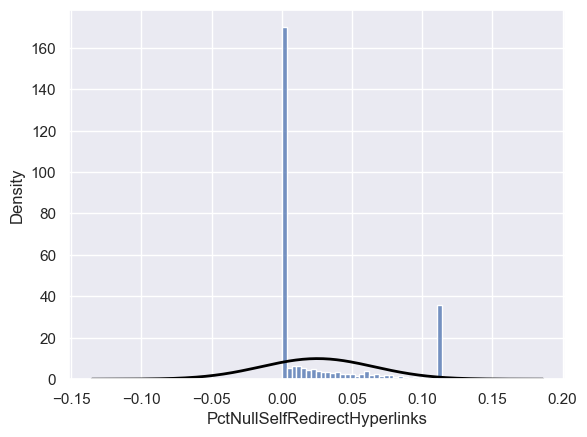

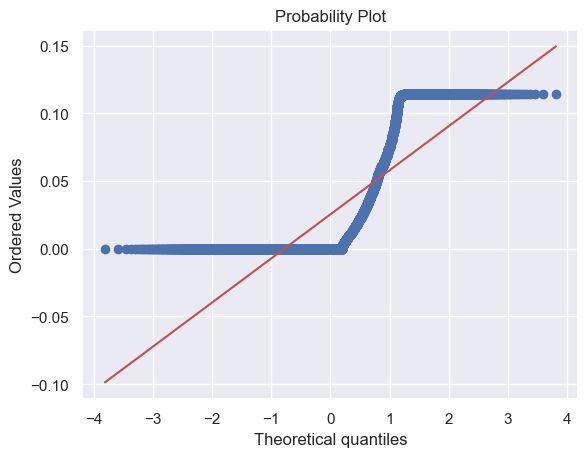

In [10]:
# Correcting outliers.
df = df[df['NumDots'] < 20]
df = df[df['NumDash'] < 40]
plt.scatter(x=df['NumDots'], y=df['NumDash'])
plt.xlabel('NumDots')
plt.ylabel('NumDash')
plt.show()
for col in continuous_columns:
    df[col], _ = yeojohnson(df[col]) 

for col_name in continuous_columns:
    fig1, ax1 = plt.subplots()
    sns.histplot(x=df[col_name], stat="density", ax=ax1)
    normal(df[col_name].mean(), df[col_name].std())
    
    fig2, ax2 = plt.subplots()
    stats.probplot(df[col_name], plot=ax2)
    
plt.show()

## Statistic model creation

### Configuration retrieval

In [11]:
# Extracting the "Class_label" column.
col = df.columns.to_list()
# Removing it from the dataset.
col.remove('CLASS_LABEL')

# Defining a new dataset.
X = df[col]
y = df["CLASS_LABEL"]

# Splitting our sample.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Defining the parameters for our algorithm.
def objective(trial):
    n_estimators = trial.suggest_int('n_estimations', 10, 300)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Creating a study to maximize accuracy by running our function 100 times.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
# Extracting the best trial to automate parameter selection.
best_trial = study.best_trial
result = best_trial.params
    

[I 2024-08-26 13:15:11,551] A new study created in memory with name: no-name-bb809d65-febe-41b3-a473-bdb47ebd5654
[I 2024-08-26 13:15:11,649] Trial 0 finished with value: 0.978 and parameters: {'n_estimations': 19, 'max_depth': 19, 'min_samples_split': 19, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.978.
[I 2024-08-26 13:15:11,778] Trial 1 finished with value: 0.97 and parameters: {'n_estimations': 46, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.978.
[I 2024-08-26 13:15:12,313] Trial 2 finished with value: 0.952 and parameters: {'n_estimations': 271, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.978.
[I 2024-08-26 13:15:12,782] Trial 3 finished with value: 0.9755 and parameters: {'n_estimations': 232, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.978.
[I 2024-08-26 13:15:13,349] Trial 4 finished with value: 0.953 and parameters: {

### Model training

In [12]:
model = RandomForestClassifier(n_estimators=result['n_estimations'], max_depth=result['max_depth'], min_samples_split=result['min_samples_split'], min_samples_leaf=result['min_samples_leaf'], random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=248, n_jobs=-1,
                       random_state=42)

### Model performance prediction

In [13]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.99      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

